#### Imports

In [60]:
from numpy import array
from numpy import mean
from numpy import cov
from numpy.linalg import eig
import os
import argparse
import shutil
import numpy as np
import imageio
import pandas as pd
import torch
from pathlib import Path
import sys
import matplotlib.pyplot as plt
sys.path.insert(0, "../../SemanticStyleGAN")
from models import make_model
from visualize.utils import generate, cubic_spline_interpolate


#### Loading Model

In [8]:
ckpt= "/no_backups/g013/checkpoints/SSG_v3.13/ckpt/140000.pt"
device="cpu"
batch=8
sample=10
steps=160
truncation=0.7
truncation_mean=10000
latent= "../results/saved_samples/second_latent.npy"

## Model Initalization
print("Loading model ...")
ckpt = torch.load(ckpt,map_location=torch.device('cpu'))
model = make_model(ckpt["args"])
model.to(device)
model.eval()
model.load_state_dict(ckpt["g_ema"])
mean_latent = model.style(
torch.randn(truncation_mean, model.style_dim, device=device)
).mean(0)
print(f'mean_latent shape is {mean_latent.shape}')
print("Generating original image ...")


with torch.no_grad():
    styles = torch.tensor(np.load(latent), device=device)
    if styles.ndim == 2:
        assert styles.size(1) == model.style_dim
        styles = styles.unsqueeze(1).repeat(1, model.n_latent, 1)
    original_img, original_seg = generate(
        model, styles, mean_latent=mean_latent, randomize_noise=False
    )


Loading model ...
Initializing model with arguments:
{'aug': False,
 'base_layers': 2,
 'batch': 4,
 'channel_multiplier': 2,
 'checkpoint_dir': '/no_backups/g013/checkpoints/SSG_v3.13',
 'ckpt': None,
 'coarse_channel': 512,
 'coarse_size': 64,
 'd_reg_every': 16,
 'dataset': '/no_backups/g013/data/lmdb_datasets/lmdb_v3.3',
 'depth_layers': 6,
 'detach_texture': False,
 'distributed': True,
 'g_reg_every': 4,
 'inception': '/no_backups/g013/data/inception_models/inception_v3.3.pkl',
 'iter': 600001,
 'lambda_mask': 100.0,
 'latent': 512,
 'local_channel': 64,
 'local_layers': 10,
 'local_rank': 0,
 'lr': 0.002,
 'min_feat_size': 16,
 'mixing': 0.3,
 'n_gpu': 4,
 'n_mlp': 8,
 'n_sample': 16,
 'num_workers': 8,
 'path_batch_shrink': 2,
 'path_regularize': 0.5,
 'r1_img': 10,
 'r1_seg': 1000,
 'residual_refine': True,
 'save_every': 5000,
 'seg_dim': 16,
 'size': 256,
 'start_iter': 0,
 'transparent_dims': (10, 12),
 'viz_every': 2000}
n_latent: 34, n_latent_expand: 160
mean_latent shape

#### Load 3 images

In [9]:
latent1= "../results/saved_samples/first_latent.npy"
latent2= "../results/saved_samples/second_latent.npy"
latent3= "../results/saved_samples/third_latent.npy"

styles1 = torch.tensor(np.load(latent1), device=device)
styles2 = torch.tensor(np.load(latent2), device=device)
styles3 = torch.tensor(np.load(latent3), device=device)

styles1 = styles1.unsqueeze(1).repeat(1, model.n_latent, 1)
styles2 = styles2.unsqueeze(1).repeat(1, model.n_latent, 1)
styles3 = styles3.unsqueeze(1).repeat(1, model.n_latent, 1)

#### Compare 2 PCA methods

In [54]:
# Goal is w0 = w + Vx
def calculate_pca_1(model,samples,n_components=10):
    '''
    Calculates PCA and return the V of shape n_components X model.style_dim    
    '''
    pca_res = torch.pca_lowrank(samples,q=n_components)
    V = pca_res[2].permute(1,0)
    print(f"Shape of output V from PCA is: {V.shape} ")
    return V

In [59]:
def calculate_pca_2(samples,selected=10):
    samples_cop = samples.cpu().detach().numpy()
    M = mean(samples_cop)
    C = samples_cop-M
    V_2=cov(C.T)
    values, vectors = eig(V_2)
    return values[:selected],vectors[:selected]

In [71]:
styles = model.style(
        torch.randn(50000, model.style_dim, device="cpu")
    )

res_1 = calculate_pca_1(model,styles)
res_2 = calculate_pca_2(styles,selected=513)
vectors = res_2[1]

Shape of output V from PCA is: torch.Size([10, 512]) 


In [52]:
vectors = torch.tensor(vectors)
torch.save(vectors,"data/principal_components_2.pt")

In [46]:
res_2[0]

array([15.91889699, 15.25948437, 13.50521601, 11.87156765, 10.17884565,
        7.64533283,  7.44033516,  6.70581546,  5.8590124 ,  5.61254082,
        5.22796099,  4.79789628,  4.54162053,  4.47765432,  4.11642747,
        3.96747068,  3.92439134,  3.65459711,  3.45641699,  3.26426704,
        3.03433673,  2.79089195,  2.69448858,  2.64423126,  2.52609709,
        2.45939989,  2.33080302,  2.21935921,  2.11806808,  2.10087064])

In [85]:
for i in range(res_2[1].shape[0]):
    print(f'for i = {i} mean is {res_2[1][i].mean()*10000} and sum is {res_2[1][i].sum()}' )

for i = 0 mean is -1.3486391029193612 and sum is -0.06905032206947129
for i = 1 mean is 16.990500439619474 and sum is 0.8699136225085171
for i = 2 mean is 3.937511832231101 and sum is 0.20160060581023237
for i = 3 mean is -5.477035299857284 and sum is -0.2804242073526929
for i = 4 mean is -6.125655587040277 and sum is -0.3136335660564622
for i = 5 mean is 22.022137561027634 and sum is 1.127533443124615
for i = 6 mean is 2.43441883859297 and sum is 0.12464224453596007
for i = 7 mean is 12.17032236282149 and sum is 0.6231205049764603
for i = 8 mean is 15.418992301687492 and sum is 0.7894524058463996
for i = 9 mean is 15.07613299381703 and sum is 0.7718980092834319
for i = 10 mean is -1.5410124508610545 and sum is -0.078899837484086
for i = 11 mean is 15.928222139651778 and sum is 0.8155249735501711
for i = 12 mean is -15.944711769871498 and sum is -0.8163692426174207
for i = 13 mean is 18.60158914877094 and sum is 0.9524013644170722
for i = 14 mean is -4.850160048564989 and sum is -0.248

#### Copied functions

In [10]:
color_map = {
    0: [0, 0, 0],  # Void
    1: [128, 64, 128],  # Road
    2: [244, 35, 232],  # Side Walk
    3: [70, 70, 70],  # Building
    4: [102, 102, 156],  # Wall
    5: [190, 153, 153],  # Fence
    6: [153, 153, 153],  # pole
    7: [250, 170, 30],  # traffic light
    8: [220, 220, 0],  # Traffic sign
    9: [107, 142, 35],  # Vegitation
    10: [70, 130, 180],  # sky
    11: [220, 20, 60],  # human
    12: [255, 0, 0],  # rider
    13: [0, 0, 142],  # car
    14: [0, 60, 100],  # other vehicles
    15: [0, 0, 230],  # bike and motorcycle
    16: [116, 95, 159], # Does not exists
}
def from_rgb_to_label(image, color_map):
    color_map_sum = {}
    new_image = np.zeros((image.shape[0], image.shape[1]))
    for c in color_map:
        color_map_sum[c] = sum(color_map[c])
    image_tensor = torch.tensor(image).to(float)
    image_summed = torch.sum(image_tensor, dim=2)
    for index in color_map_sum:
        mask = image_summed == color_map_sum[index]
        new_image[mask] = index
    return new_image
## Gets class distribution from segmentation map
def get_class_dist(seg,color_map):
    converted_seg = from_rgb_to_label(seg, color_map)
    sem_seg_tensor = torch.tensor(converted_seg)
    sem_seg_unsqueezed = sem_seg_tensor.reshape(-1)
    res = torch.nn.functional.one_hot(sem_seg_unsqueezed.to(torch.int64), 16)
    final_res = res.reshape(
        sem_seg_tensor.shape[0], sem_seg_tensor.shape[1], -1
    ).float()
    mean_val = torch.mean(final_res, dim=(0, 1))
    mean_val = mean_val.unsqueeze(0)
    return mean_val


### Testing Fourier Features Effect

In [132]:
## Editing Functions 

def images_to_video(images,segs,save_dir):
    frames = [np.concatenate((img, seg), 1) for (img, seg) in zip(images, segs)]
    imageio.mimwrite(
    f"{save_dir}", frames, fps=20
    )
    
def generate_and_plot_image(styles,class_index,coords=None,plot=True,get_image=True):
    image, seg = generate(
            model,
            styles[0].unsqueeze(0),
            mean_latent=mean_latent,
            randomize_noise=False,
            batch_size=batch,
            coords=coords
        )
   
    all_classes=get_class_dist(seg[0],color_map)
    class_percentage=(all_classes[0][class_index]/all_classes.sum())*100
  
    if plot:
        print(f'Class percentage is {class_percentage}')
        plt.imshow(np.concatenate((image[0],seg[0]),1))
        plt.show()
    if get_image:
        return image,seg
    else:
        return float(class_percentage)
def edit_image(latent_index,class_index,change_factor,styles,addition=True,plot=True,get_image=True,add_mean_latent=False):

    styles_copy = styles.clone().detach()
    if addition:
        styles_copy[0,latent_index]+=(change_factor) 
    else:
        styles_copy[0,latent_index]*=(change_factor) 
    if add_mean_latent:
                styles_copy[0,latent_index] = 0.8 * styles_copy[0,latent_index] + (
                         1 - 0.8
                ) * mean_latent.unsqueeze(0)
    return generate_and_plot_image(styles_copy,class_index,plot=plot,get_image=get_image)

def edit_image_principal_component(latent_index,class_index,change_factor,styles,principal_component,whole_image=False,plot=True,get_image=True):

    styles_copy = styles.clone().detach()
    if not whole_image:
        if isinstance(principal_component,list):
            for pc in principal_component:
                styles_copy[0,latent_index]+=(pc*change_factor) 
        else:
         styles_copy[0,latent_index]+=(principal_component*change_factor) 
    else:
        principal_component= principal_component.unsqueeze(0).unsqueeze(0).repeat(1, model.n_latent, 1)
        styles_copy = styles_copy + (principal_component.float()*change_factor)
    return generate_and_plot_image(styles_copy,class_index,plot=plot,get_image=get_image)

In [12]:
## Playing with coords.
#edit_image(latent_index=28,class_index=13,change_factor=-0.7,styles=styles1)
def make_coords(b, h, w, device,factor=0):
    start = -1 - factor
    end = 1 + factor
    x_channel = (
        torch.linspace(start, end, w, device=device).view(1, 1, 1, -1).repeat(b, 1, w, 1)
    )
    y_channel = (
        torch.linspace(start, end, h, device=device).view(1, 1, -1, 1).repeat(b, 1, 1, h)
    )
    return torch.cat((x_channel, y_channel), dim=1)
coarse_size = 64
latent=16
class_index = 13
## Gradual addition of a small multiplicator to the coordination values of ff
images=[]
segs=[]
# for i in np.arange(-0.4,0.4,0.01):
#     coords = make_coords(
#         1, coarse_size, coarse_size, "cpu"
#     )+i
#     coords = [coords.clone() for _ in range(latent)]
#     image,seg=generate_and_plot_image(styles1,class_index,coords,plot=False)
#     images.append(image[0])
#     segs.append(seg[0])

## For a specific class ( Car )
images=[]
segs=[]
for i in np.arange(-0.5,1.5,0.01):
    coords = make_coords(
        1, coarse_size, coarse_size, "cpu"
    )
    coords = [coords.clone() for _ in range(latent)]
    #Scaling 0:horizontally and 1:vertically
    coords[class_index][:,1]+=i

    ##Zooming in on a class ,smaller value zoom in , large value zoom out
    # coords[class_index]=make_coords(
    #     1, coarse_size, coarse_size, "cpu",i
    # )
    image,seg=generate_and_plot_image(styles2,class_index,coords,plot=False)
    images.append(image[0])
    segs.append(seg[0])

KeyboardInterrupt: 

In [19]:
images_to_video(images,segs,"./data/scaling_vertically_car_class_2.mp4")

#### Controllability Graph

In [109]:
def extract_class_statistics_addition(style,class_index,latent_index):
    distribution=[]
    factor=[]
    original_dist = edit_image(latent_index,class_index,0,style,plot=False,get_image=False,add_mean_latent=False)
    for change_factor in np.arange(-1,1,0.01):
        dist=edit_image(latent_index,class_index,change_factor,style,plot=False,get_image=False,add_mean_latent=False)
        dist = float(dist)
        factor.append(round(change_factor,3))
        distribution.append(round(dist,3))
    df = pd.DataFrame({"addition_factor":factor,"dist":distribution})
    df = df[df["dist"].between(0.5,35)]
    return df
 

In [131]:
def extract_class_statistics_pca(style,class_index,latent_index,V):
    distribution=[]
    factor=[]
    #original_dist = edit_image(latent_index,class_index,0,style,plot=False,get_image=False,add_mean_latent=False)
    for change_factor in np.arange(-40,30,1):
        dist=edit_image_principal_component(latent_index,class_index,change_factor,style,V,whole_image=False,plot=False,get_image=False)
        dist = float(dist)
        factor.append(round(change_factor,3))
        distribution.append(round(dist,3))
    df = pd.DataFrame({"addition_factor":factor,"dist":distribution})
    df = df[df["dist"].between(0.5,35)]
    return df
 

In [36]:
latent_list = [styles1,styles2,styles3]
class_index = 13
latent_index=28
list_df=[]
for latent in latent_list:
    class_statistics_df=extract_class_statistics_addition(latent,class_index,latent_index)
    list_df.append(class_statistics_df)

In [142]:
def plot_class_dist_change(list_df,save_dir=None):
    fig,ax = plt.subplots()
    for i,df in enumerate(list_df):
        ax.plot(df["addition_factor"],df["dist"],label=i)
    y_range = np.arange(0,40,4)
    ax.plot(np.zeros(10),y_range,linestyle="dashed")
    ax.set_yticks(y_range)
    #ax.set_xticks(np.arange(-1,1,0.1))#For Addition
    ax.set_xticks(np.arange(-40,30,5))#For PCA 2
    ax.set_xlabel("addition_factor")
    ax.set_ylabel("distribution #")
    if save_dir is not None:
        plt.savefig(save_dir)
    plt.show()  

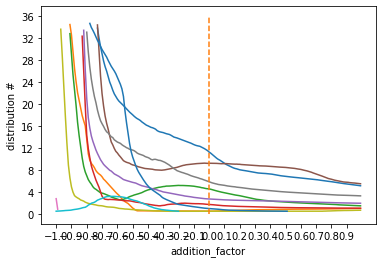

In [122]:
plot_class_dist_change(list_df[10:])

ValueError: x and y must have same first dimension, but have shapes (11,) and (10,)

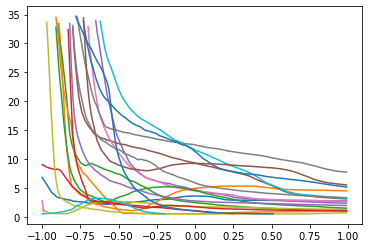

In [110]:
latent_dir = "/usrhomes/g013/SemanticStyleGAN/results/controlled_samples"
all_latent = Path(latent_dir).glob('*.npy')

class_index = 13
latent_index=28
list_df=[]
styles_list=[]
for latent in all_latent:
    style = torch.tensor(np.load(latent), device=device)
    style = style.unsqueeze(1).repeat(1, model.n_latent, 1)
    styles_list.append(style)
    if len(styles_list)>20:
        break

for latent in styles_list:
    class_statistics_df=extract_class_statistics_addition(latent,class_index,latent_index)
    list_df.append(class_statistics_df)
plot_class_dist_change(list_df)
    

#### Graph for PCA

Class percentage is 3.045654296875


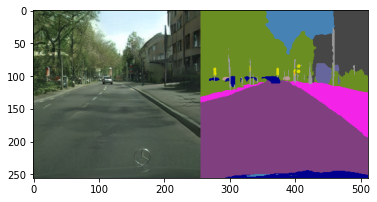

Class percentage is 8.0230712890625


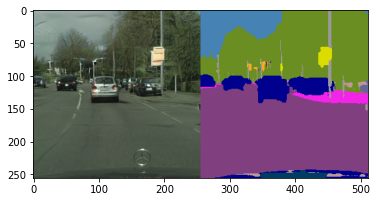

Class percentage is 14.459228515625


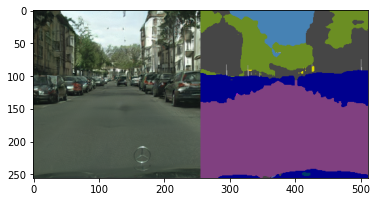

In [128]:
V = torch.load("data/principal_components_2.pt") #Manual output
latent_list = [styles1,styles2,styles3]
class_index = 13
latent_index=28
list_df=[]
for latent in latent_list:
    class_statistics_df=extract_class_statistics_pca(latent,class_index,latent_index,[V[1],V[3]])
    list_df.append(class_statistics_df)

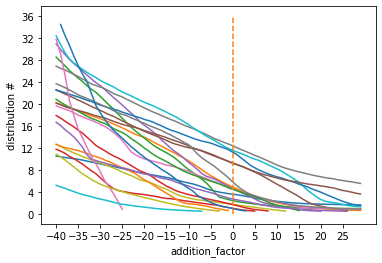

In [141]:
latent_dir = "/usrhomes/g013/SemanticStyleGAN/results/controlled_samples"
all_latent = Path(latent_dir).glob('*.npy')
V = torch.load("data/principal_components_2.pt") #Manual output
class_index = 13
latent_index=28
list_df=[]
styles_list=[]
for latent in all_latent:
    style = torch.tensor(np.load(latent), device=device)
    style = style.unsqueeze(1).repeat(1, model.n_latent, 1)
    styles_list.append(style)
    if len(styles_list)>20:
        break

for latent in styles_list:
    class_statistics_df=extract_class_statistics_pca(latent,class_index,latent_index,[V[1],V[3]])
    list_df.append(class_statistics_df)
plot_class_dist_change(list_df)
    

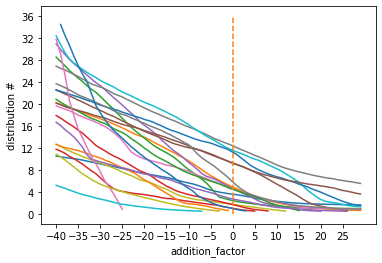

In [143]:
plot_class_dist_change(list_df)

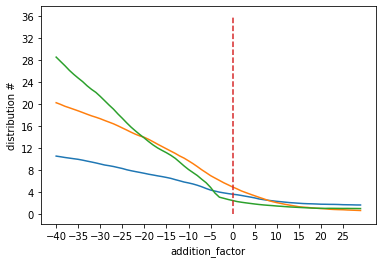

In [140]:
plot_class_dist_change(list_df)